In [67]:
import os
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from europa_seismo.europa_seismo import rayleigh, minos
from scipy.interpolate import interp1d
from pymc.Matplot import plot
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

### Read sample dispersion data

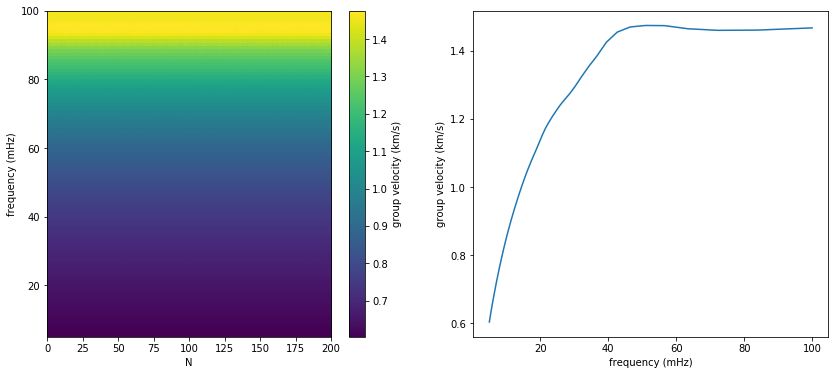

In [68]:
#data_obs = np.loadtxt('../data/dispersion_curves/disp_icehot20_test.dat')
Tmin = 10
Tmax = 200
nT = 100
periods = np.linspace(Tmin,Tmax,nT)

data_matrix = np.load('/home/romaguir/Tools/europa_seismo/data/dispersion_curves/data_matrix_nl0.01.npy')
group_vel_obs = np.average(data_matrix,axis=1)
f_obs = (1. / periods) * 1000.0
km_per_deg = 27.31
t_obs = (30.0 * km_per_deg) / group_vel_obs
#print group_vel_obs


fig, axes = plt.subplots(ncols=2,figsize=(14,6))
im1 = axes[0].imshow(data_matrix,aspect='auto',extent=[0,200,(1./Tmax)*1000.,(1./Tmin)*1000.])
axes[0].set_xlabel('N')
axes[0].set_ylabel('frequency (mHz)')
fig.colorbar(im1,ax=axes[0],label='group velocity (km/s)')
#axes[1].plot(periods,group_vel_obs)
axes[1].plot(f_obs,group_vel_obs)
axes[1].set_ylabel("group velocity (km/s)")
axes[1].set_xlabel('frequency (mHz)')
plt.show()


### Define Monte Carlo model

In [69]:
#get current working directory
cwd = os.getcwd()

#shear velocity of ice is assumed to be 2.0 km /s
vs_i = 2.0

#define stochastic variables
h_r = pm.Uniform('h_r',lower=0.0,upper=2.0) #regolith thickness
h_i = pm.Uniform('h_i',lower=h_r,upper=50.0) #ice thickness
vs_r = pm.Uniform('vs_r',lower=0.5,upper=3.5) #regolith shear velocity
gcarc = pm.Uniform('gcarc',lower=10.0,upper=50.0) # distance from event

#define data variance
#sigma = 0.1
sigma = 5.0
tau = np.power(sigma,-2)

#define forward model
@pm.deterministic
def mu(h_r=h_r, vs_r=vs_r, h_i=h_i, vs_i=vs_i, gcarc=gcarc):
    
    #write current model
    h2o_thickness = 1565000.0 - 1438875
    ocean_thickness = h2o_thickness - (h_i*1000.0)
    layers = rayleigh.make_layers_dict(regolith_thickness = h_r*1000.0,
                                       ice_thickness = h_i*1000.0,
                                       ocean_thickness = ocean_thickness,
                                       vp_regolith=4000.,
                                       vs_regolith=vs_r*1000.0,
                                       vs_ice=vs_i*1000.0)
    
    rayleigh.write_deck_model(layers,output_model='europa.deck',
                              base_model=cwd+'/../data/models/'+'icehot_20km_simple.txt')

    
    #run current model
    modesfile='modes.out'
    eigfile='eig.out'
    eps=1e-10
    wgrav=1.315
    jcom=3
    lmin=0
    lmax=1000
    wmin=0.1
    wmax=100.0 #10 s period
    nmin=0.0                                                                    
    nmax=0.0

    modelfile='europa.deck'
    minos.main(modelfile,modesfile,eigfile,eps,wgrav,jcom,lmin,lmax,wmin,wmax,nmin,nmax)
    f = np.genfromtxt('modes.out')
    freq_mhz = f[:,4]
    group_vel = f[:,6] #group velocity
    
    #interpolate to observed frequencies
    freq_interp = interp1d(freq_mhz,group_vel,bounds_error=None,fill_value='extrapolate')
    vel_modeled = freq_interp(f_obs)
    
    # use delta to convert distpersion curves from velocity to time

    t_p = (gcarc * km_per_deg) / vel_modeled
    t_0 = (1./len(t_p))*np.sum(t_p-t_obs)
    print 't_0 = ', t_0
    t_p_optimal = t_p - t_0
    
    
    return t_p_optimal

#define likelyhood
y = pm.Normal('y', mu=mu, tau=tau, value=t_obs, observed=True)

#inference
m = pm.Model([h_r,h_i,vs_r,gcarc,tau,y])
mc = pm.MCMC(m)
mc.sample(iter=1000,burn=500)

t_0 =  -579.218982726
t_0 =  -579.265780334
t_0 =  -344.504470328
t_0 =  -579.242465297
 [                  0%                  ] 2 of 1000 complete in 3.2 sect_0 =  -579.196063282
 [                  0%                  ] 3 of 1000 complete in 4.4 sect_0 =  -579.202903473
t_0 =  -167.943810449
t_0 =  -571.363540722
 [                  0%                  ] 4 of 1000 complete in 7.4 sect_0 =  -568.301214799
t_0 =  -568.307466449
 [                  0%                  ] 5 of 1000 complete in 9.1 sect_0 =  -383.198735294
 [                  0%                  ] 6 of 1000 complete in 10.0 sect_0 =  -410.503778258
t_0 =  -383.193938051
 [                  0%                  ] 7 of 1000 complete in 12.4 sect_0 =  -383.220652282
t_0 =  -407.079298864
 [                  0%                  ] 8 of 1000 complete in 14.7 sect_0 =  -383.253943469
t_0 =  -383.196805416
 [                  0%                  ] 9 of 1000 complete in 16.3 sect_0 =  -383.186057739
t_0 =  -462.624071386
 [        

 [--                6%                  ] 65 of 1000 complete in 105.4 sect_0 =  -38.9709467363
t_0 =  505.524088789
t_0 =  -81.3278798378
 [--                6%                  ] 66 of 1000 complete in 106.9 sect_0 =  -224.880986061
t_0 =  -74.4030968334
 [--                6%                  ] 67 of 1000 complete in 107.9 sect_0 =  -77.4234675323
t_0 =  154.162319973
t_0 =  -76.7318835784
 [--                6%                  ] 68 of 1000 complete in 109.5 sect_0 =  490.88029897
t_0 =  -494.747112359
t_0 =  -79.9358053374
 [--                6%                  ] 69 of 1000 complete in 111.8 sect_0 =  -74.8764323485
 [--                7%                  ] 70 of 1000 complete in 112.3 sect_0 =  -160.412034288
t_0 =  -73.9419128188
 [--                7%                  ] 71 of 1000 complete in 113.3 sect_0 =  -76.3852387835
 [--                7%                  ] 72 of 1000 complete in 113.9 sect_0 =  -80.6639886808
t_0 =  -85.6748200693
t_0 =  -77.8830661063
 [--            

t_0 =  -82.1520791437
 [----             12%                  ] 127 of 1000 complete in 201.5 sect_0 =  -73.9897314776
t_0 =  -620.01827325
t_0 =  -72.436756976
 [----             12%                  ] 128 of 1000 complete in 203.1 sect_0 =  -78.900761864
t_0 =  -359.697161061
t_0 =  -78.0692688633
 [----             12%                  ] 129 of 1000 complete in 204.6 sect_0 =  -52.1490309596
t_0 =  -139.020659862
t_0 =  -82.7278321
 [----             13%                  ] 130 of 1000 complete in 206.2 sect_0 =  -80.4073935892
t_0 =  642.770144449
t_0 =  -473.968915751
t_0 =  -75.0952394035
 [----             13%                  ] 131 of 1000 complete in 208.6 sect_0 =  560.740385854
t_0 =  -77.7148834827
 [-----            13%                  ] 132 of 1000 complete in 209.6 sect_0 =  382.130414519
t_0 =  -75.45457108
 [-----            13%                  ] 133 of 1000 complete in 210.6 sect_0 =  -80.4198861032
t_0 =  113.092455589
t_0 =  -446.412806814
t_0 =  -75.6936825116
 [-

 [-------          18%                  ] 187 of 1000 complete in 295.1 sect_0 =  309.531593917
t_0 =  -256.089300418
t_0 =  -75.9127652389
 [-------          18%                  ] 188 of 1000 complete in 296.8 sect_0 =  -76.6242293409
t_0 =  -82.0452693902
 [-------          18%                  ] 189 of 1000 complete in 297.8 sect_0 =  -72.9153670119
t_0 =  -252.79183729
t_0 =  -72.9989410663
 [-------          19%                  ] 190 of 1000 complete in 299.3 sect_0 =  -70.7099186313
t_0 =  -408.277772964
t_0 =  -75.7255530122
 [-------          19%                  ] 191 of 1000 complete in 300.9 sect_0 =  -345.966059269
t_0 =  -441.667545582
t_0 =  -71.8170047683
 [-------          19%                  ] 192 of 1000 complete in 302.6 sect_0 =  -74.626219392
t_0 =  -301.087189733
t_0 =  -483.819927566
t_0 =  -74.5627898174
 [-------          19%                  ] 193 of 1000 complete in 305.1 sect_0 =  -450.294988069
t_0 =  -79.5454863894
 [-------          19%                

t_0 =  -78.455129193
 [---------        25%                  ] 250 of 1000 complete in 386.3 sect_0 =  -82.2910345707
 [---------        25%                  ] 251 of 1000 complete in 386.8 sect_0 =  -77.0226260304
t_0 =  627.067817512
t_0 =  -399.38856706
t_0 =  -76.1748966196
 [---------        25%                  ] 252 of 1000 complete in 389.0 sect_0 =  -64.5272710352
t_0 =  -454.326709312
t_0 =  -75.2013345403
 [---------        25%                  ] 253 of 1000 complete in 390.7 sect_0 =  301.669237412
t_0 =  -197.258560778
t_0 =  -72.2466414447
 [---------        25%                  ] 254 of 1000 complete in 392.3 sect_0 =  -74.6777718744
t_0 =  -126.736206938
t_0 =  -75.9319776429
 [---------        25%                  ] 255 of 1000 complete in 393.8 sect_0 =  -75.8075544582
t_0 =  -13.4419728178
t_0 =  -75.5649600954
 [---------        25%                  ] 256 of 1000 complete in 395.3 sect_0 =  -75.3391588432
t_0 =  432.340479459
t_0 =  -494.141455972
t_0 =  -68.1548637

 [-----------      31%                  ] 312 of 1000 complete in 477.4 sect_0 =  -73.9210042379
t_0 =  41.912789699
t_0 =  -76.6735842927
 [-----------      31%                  ] 313 of 1000 complete in 478.9 sect_0 =  -50.016155517
t_0 =  -418.831844702
t_0 =  -390.935970528
t_0 =  -78.444534585
 [-----------      31%                  ] 314 of 1000 complete in 481.0 sect_0 =  -347.99764953
t_0 =  -86.4411507587
 [-----------      31%                  ] 315 of 1000 complete in 482.1 sect_0 =  -78.0663817154
 [------------     31%                  ] 316 of 1000 complete in 482.6 sect_0 =  -77.3870615354
t_0 =  -76.637592661
 [------------     31%                  ] 317 of 1000 complete in 483.6 sect_0 =  37.039386436
t_0 =  -72.2005294128
 [------------     31%                  ] 318 of 1000 complete in 484.6 sect_0 =  -74.8764042353
 [------------     31%                  ] 319 of 1000 complete in 485.2 sect_0 =  -155.332829168
t_0 =  -78.6299276531
 [------------     32%            

t_0 =  -81.8698261843
 [--------------   37%                  ] 375 of 1000 complete in 568.3 sect_0 =  -75.0251374801
t_0 =  -602.21353018
t_0 =  -80.5838561432
 [--------------   37%                  ] 376 of 1000 complete in 569.8 sect_0 =  255.576849063
t_0 =  -476.810496362
t_0 =  -81.1783815242
 [--------------   37%                  ] 377 of 1000 complete in 572.0 sect_0 =  -77.0489023054
t_0 =  -516.445842842
t_0 =  -76.1577209742
 [--------------   37%                  ] 378 of 1000 complete in 574.0 sect_0 =  -71.6262776242
t_0 =  78.3982539393
t_0 =  -67.106311832
 [--------------   37%                  ] 379 of 1000 complete in 576.0 sect_0 =  -67.0961703896
t_0 =  -74.7478852668
 [--------------   38%                  ] 380 of 1000 complete in 577.2 sect_0 =  -44.6611544856
t_0 =  -405.125126116
t_0 =  -84.6258745726
 [--------------   38%                  ] 381 of 1000 complete in 579.4 sect_0 =  -41.9493411607
t_0 =  108.326712854
t_0 =  -81.1892294396
 [--------------  

 [---------------- 43%                  ] 437 of 1000 complete in 663.8 sect_0 =  -484.262292695
t_0 =  -78.555265449
 [---------------- 43%                  ] 438 of 1000 complete in 665.4 sect_0 =  -73.468439216
t_0 =  -149.683028892
t_0 =  -428.163931615
t_0 =  -81.4965370046
 [---------------- 43%                  ] 439 of 1000 complete in 667.8 sect_0 =  -79.624196474
t_0 =  523.138374626
t_0 =  -78.555265449
 [---------------- 44%                  ] 440 of 1000 complete in 669.4 sect_0 =  -70.718317843
t_0 =  66.8251191524
t_0 =  -75.2093919532
 [---------------- 44%                  ] 441 of 1000 complete in 670.9 sect_0 =  -38.6447412444
t_0 =  27.8131428175
t_0 =  -497.299003278
t_0 =  -74.8472030296
 [---------------- 44%                  ] 442 of 1000 complete in 673.8 sect_0 =  -336.039581931
t_0 =  -496.264607133
t_0 =  -81.028967972
 [---------------- 44%                  ] 443 of 1000 complete in 676.8 sect_0 =  -74.3632936734
 [---------------- 44%                  ] 44

 [-----------------49%                  ] 498 of 1000 complete in 770.3 sect_0 =  -43.2789739286
t_0 =  -75.3651045055
 [-----------------49%                  ] 499 of 1000 complete in 772.0 sect_0 =  -80.165258689
t_0 =  -68.6513516787
t_0 =  -81.6448681211
 [-----------------50%                  ] 500 of 1000 complete in 774.3 sect_0 =  -79.5169896999
t_0 =  471.784375976
t_0 =  -476.819514096
t_0 =  -80.3589992807
 [-----------------50%                  ] 501 of 1000 complete in 778.3 sect_0 =  -52.5584936114
t_0 =  140.491258429
t_0 =  -81.0613902883
 [-----------------50%                  ] 502 of 1000 complete in 779.9 sect_0 =  -32.0658386979
t_0 =  -246.283818792
t_0 =  -78.7101715418
 [-----------------50%                  ] 503 of 1000 complete in 781.7 sect_0 =  -489.260944372
t_0 =  -75.7263217769
 [-----------------50%                  ] 504 of 1000 complete in 783.5 sect_0 =  -75.8465907822
 [-----------------50%                  ] 505 of 1000 complete in 784.0 sect_0 =  

 [-----------------56%-                 ] 560 of 1000 complete in 872.2 sect_0 =  -80.2876005319
 [-----------------56%-                 ] 561 of 1000 complete in 872.8 sect_0 =  -67.6601111817
t_0 =  -330.899682468
t_0 =  -80.4043629779
 [-----------------56%-                 ] 562 of 1000 complete in 874.5 sect_0 =  -474.384129495
t_0 =  -80.2876005319
 [-----------------56%-                 ] 563 of 1000 complete in 876.0 sect_0 =  118.67287792
t_0 =  -76.8676313584
 [-----------------56%-                 ] 564 of 1000 complete in 877.1 sect_0 =  -72.4075784096
 [-----------------56%-                 ] 565 of 1000 complete in 877.7 sect_0 =  -192.045261724
t_0 =  -401.567552123
t_0 =  -79.1159302076
 [-----------------56%-                 ] 566 of 1000 complete in 879.5 sect_0 =  -72.951843259
t_0 =  612.645220082
t_0 =  -66.0700102233
 [-----------------56%-                 ] 567 of 1000 complete in 881.1 sect_0 =  -85.3572012468
 [-----------------56%-                 ] 568 of 100

 [-----------------62%---               ] 622 of 1000 complete in 973.3 sect_0 =  -397.510144391
t_0 =  -86.8488687539
 [-----------------62%---               ] 623 of 1000 complete in 974.7 sect_0 =  -86.3245195542
t_0 =  -41.6256872026
t_0 =  -483.115829587
t_0 =  -87.1684365997
 [-----------------62%---               ] 624 of 1000 complete in 977.4 sect_0 =  -86.4216867991
 [-----------------62%---               ] 625 of 1000 complete in 978.0 sect_0 =  -32.9179381461
t_0 =  474.659481298
t_0 =  -85.7794332189
 [-----------------62%---               ] 626 of 1000 complete in 979.7 sect_0 =  -443.043596262
t_0 =  -81.7726831161
 [-----------------62%---               ] 627 of 1000 complete in 980.8 sect_0 =  -486.496984519
t_0 =  -80.124891227
 [-----------------62%---               ] 628 of 1000 complete in 982.6 sect_0 =  -81.4486928779
t_0 =  -85.4575794696
 [-----------------62%---               ] 629 of 1000 complete in 984.0 sect_0 =  -473.101601778
t_0 =  -81.5536600988
 [----

t_0 =  -75.176133195
 [-----------------68%-----             ] 683 of 1000 complete in 1076.6 sect_0 =  -60.6886524326
t_0 =  240.609531468
t_0 =  -463.189069071
t_0 =  -77.5491285141
 [-----------------68%-----             ] 684 of 1000 complete in 1079.0 sect_0 =  415.14189538
t_0 =  -75.403319639
 [-----------------68%------            ] 685 of 1000 complete in 1080.2 sect_0 =  -83.0473772132
t_0 =  -74.26407815
 [-----------------68%------            ] 686 of 1000 complete in 1081.3 sect_0 =  192.163101768
t_0 =  -71.3857277938
 [-----------------68%------            ] 687 of 1000 complete in 1082.4 sect_0 =  -71.7676890511
t_0 =  -80.8901884605
 [-----------------68%------            ] 688 of 1000 complete in 1083.5 sect_0 =  -71.4156178549
t_0 =  -429.536865783
t_0 =  -79.4499174325
 [-----------------68%------            ] 689 of 1000 complete in 1085.3 sect_0 =  -81.8815972146
 [-----------------69%------            ] 690 of 1000 complete in 1085.9 sect_0 =  -82.7805117816
t_0 

 [-----------------74%--------          ] 742 of 1000 complete in 1182.0 sect_0 =  -72.4312542135
t_0 =  -454.25981776
t_0 =  -78.6583586429
 [-----------------74%--------          ] 743 of 1000 complete in 1183.7 sect_0 =  -85.0752403814
t_0 =  391.362963633
t_0 =  -75.1839791764
 [-----------------74%--------          ] 744 of 1000 complete in 1185.3 sect_0 =  393.189713269
t_0 =  -366.882675324
t_0 =  -81.3032726196
 [-----------------74%--------          ] 745 of 1000 complete in 1186.9 sect_0 =  -79.8113225233
t_0 =  262.130229346
t_0 =  -78.71700811
 [-----------------74%--------          ] 746 of 1000 complete in 1188.4 sect_0 =  -53.7784878995
t_0 =  -483.801065522
t_0 =  -78.6071809931
 [-----------------74%--------          ] 747 of 1000 complete in 1190.4 sect_0 =  -68.5595069926
t_0 =  381.510762858
t_0 =  -77.6156108704
 [-----------------74%--------          ] 748 of 1000 complete in 1192.0 sect_0 =  -44.497878005
t_0 =  -80.5738377777
 [-----------------74%--------      

t_0 =  -69.5283682299
 [-----------------80%----------        ] 803 of 1000 complete in 1282.4 sect_0 =  -84.9567222192
t_0 =  -78.7136997486
 [-----------------80%----------        ] 804 of 1000 complete in 1283.6 sect_0 =  -85.9753461817
t_0 =  544.54719511
t_0 =  -75.8861432203
 [-----------------80%----------        ] 805 of 1000 complete in 1285.3 sect_0 =  -474.520231322
t_0 =  -79.5840155375
 [-----------------80%----------        ] 806 of 1000 complete in 1286.8 sect_0 =  -86.8043826387
t_0 =  -445.99839258
t_0 =  -79.3908365349
 [-----------------80%----------        ] 807 of 1000 complete in 1288.6 sect_0 =  -77.6305859548
t_0 =  -77.2242451575
 [-----------------80%----------        ] 808 of 1000 complete in 1289.9 sect_0 =  -47.6972671093
t_0 =  -123.518347625
t_0 =  -405.797723462
t_0 =  -81.7511105823
 [-----------------80%----------        ] 809 of 1000 complete in 1292.2 sect_0 =  311.726049306
t_0 =  -480.011187309
t_0 =  -80.4523179683
 [-----------------81%----------

t_0 =  -74.2575641412
 [-----------------86%------------      ] 864 of 1000 complete in 1385.3 sect_0 =  -60.6965700315
t_0 =  -489.41635683
t_0 =  -79.7596127374
 [-----------------86%------------      ] 865 of 1000 complete in 1387.6 sect_0 =  -76.7081488053
 [-----------------86%------------      ] 866 of 1000 complete in 1388.2 sect_0 =  -67.0688008527
t_0 =  -317.470875003
t_0 =  -458.578648245
t_0 =  -77.025817277
 [-----------------86%------------      ] 867 of 1000 complete in 1390.7 sect_0 =  -85.1684094198
t_0 =  -28.9201968817
t_0 =  -498.297146184
t_0 =  -81.3205811125
 [-----------------86%------------      ] 868 of 1000 complete in 1393.8 sect_0 =  -12.2478940625
t_0 =  -497.889554721
t_0 =  -88.0596148732
 [-----------------86%-------------     ] 869 of 1000 complete in 1396.3 sect_0 =  -41.4741137586
t_0 =  382.277579883
t_0 =  -81.0092632067
 [-----------------87%-------------     ] 870 of 1000 complete in 1398.1 sect_0 =  324.395447431
t_0 =  -77.5542294611
 [--------

 [-----------------92%---------------   ] 923 of 1000 complete in 1493.4 sect_0 =  -134.861570561
t_0 =  -74.6586638402
 [-----------------92%---------------   ] 924 of 1000 complete in 1494.5 sect_0 =  -84.2324377183
t_0 =  -282.019823645
t_0 =  -71.0007147809
 [-----------------92%---------------   ] 925 of 1000 complete in 1496.2 sect_0 =  -54.2608748678
t_0 =  -398.671912877
t_0 =  -76.927591537
 [-----------------92%---------------   ] 926 of 1000 complete in 1498.0 sect_0 =  -618.39208478
t_0 =  -77.951935682
 [-----------------92%---------------   ] 927 of 1000 complete in 1499.3 sect_0 =  401.69743989
t_0 =  1207.62234907
t_0 =  -75.3830997622
 [-----------------92%---------------   ] 928 of 1000 complete in 1501.2 sect_0 =  -69.2201164657
t_0 =  -81.2984023086
 [-----------------92%---------------   ] 929 of 1000 complete in 1502.3 sect_0 =  -52.3453185205
t_0 =  257.245040513
t_0 =  -80.4916462855
 [-----------------93%---------------   ] 930 of 1000 complete in 1504.0 sect_0

 [-----------------98%----------------- ] 983 of 1000 complete in 1598.4 sect_0 =  -184.357175509
t_0 =  -486.551637517
t_0 =  -75.4329821213
 [-----------------98%----------------- ] 984 of 1000 complete in 1600.8 sect_0 =  341.522817818
t_0 =  -77.9307512803
 [-----------------98%----------------- ] 985 of 1000 complete in 1601.9 sect_0 =  -43.7897205474
t_0 =  -492.682418613
t_0 =  -78.4028552906
 [-----------------98%----------------- ] 986 of 1000 complete in 1604.3 sect_0 =  -52.9869150255
t_0 =  278.284357761
t_0 =  -79.4610471876
 [-----------------98%----------------- ] 987 of 1000 complete in 1605.9 sect_0 =  543.65032799
t_0 =  -76.6267297065
 [-----------------98%----------------- ] 988 of 1000 complete in 1606.9 sect_0 =  -79.3903526291
t_0 =  -83.7294678014
 [-----------------98%----------------- ] 989 of 1000 complete in 1608.1 sect_0 =  -68.331039692
t_0 =  -482.138739478
t_0 =  -79.5159788887
 [-----------------99%----------------- ] 990 of 1000 complete in 1610.2 sect

Plotting h_i
Plotting vs_r
Plotting h_r
Plotting gcarc


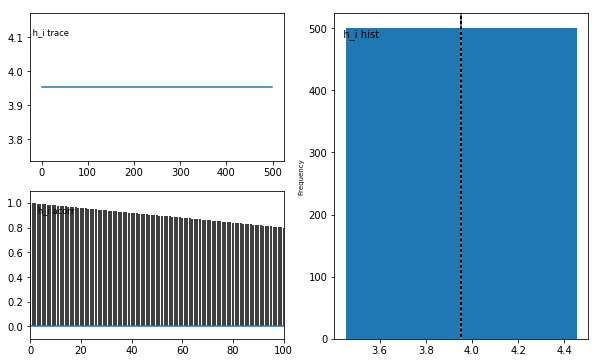

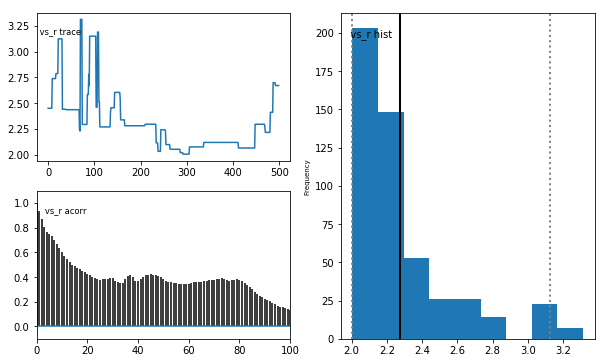

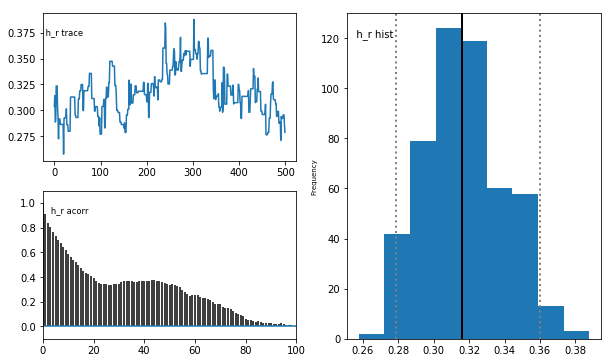

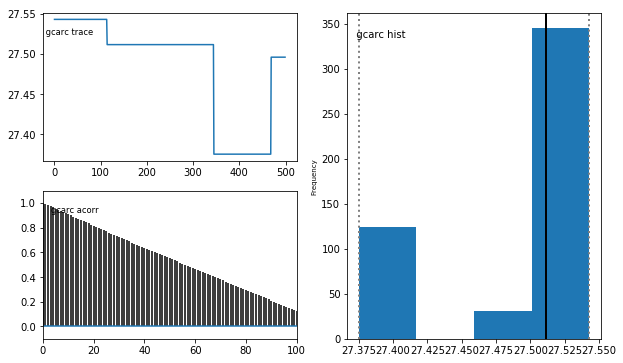

In [70]:
plot(mc)

In [72]:
h2o_thickness = 1565000.0 - 1438875
h_r_mean =  np.mean(h_r.trace())
h_i_mean =  np.mean(h_i.trace())
vs_r_mean =  np.mean(vs_r.trace())
#vs_i_mean =  np.mean(vs_i.trace())
ocean_thickness = h2o_thickness - (h_i_mean*1000.0)

### Compare mean model with target model

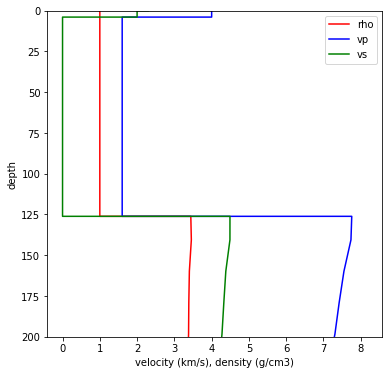

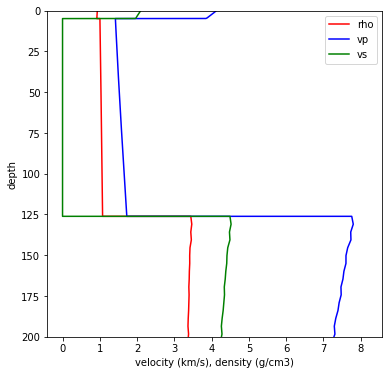

In [73]:
layers = rayleigh.make_layers_dict(regolith_thickness = h_r_mean*1000.0,
                                    ice_thickness = h_i_mean*1000.0,
                                    ocean_thickness = ocean_thickness,
                                    vp_regolith=4000.,
                                    vs_regolith=vs_r_mean*1000.0,
                                    vs_ice=vs_i*1000.0)

rayleigh.write_deck_model(layers,output_model='europa_mean.deck',
                          base_model=cwd+'/../data/models/'+'icehot_20km_simple.txt')
rayleigh.plot_deck_model('europa_mean.deck')
#rayleigh.plot_deck_model('../data/models/icehot_20km_simple.txt')
rayleigh.plot_deck_model('../data/models/icehot_5km_prem.txt')

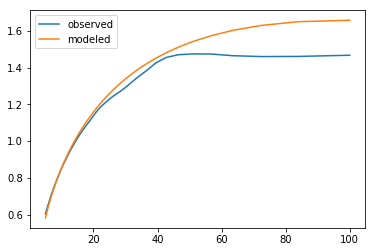

In [75]:
#run current model
modesfile='modes.out'
eigfile='eig.out'
eps=1e-10
wgrav=1.315
jcom=3
lmin=0
lmax=1000
wmin=0.1
wmax=100.0 #10 s period
nmin=0.0                                                                    
nmax=0.0

modelfile='europa_mean.deck'
minos.main(modelfile,modesfile,eigfile,eps,wgrav,jcom,lmin,lmax,wmin,wmax,nmin,nmax)
f = np.genfromtxt('modes.out')
freq_mhz = f[:,4]
group_vel = f[:,6] #group velocity
    
#interpolate to observed frequencies
freq_interp = interp1d(freq_mhz,group_vel,bounds_error=None,fill_value='extrapolate')
vel_modeled = freq_interp(f_obs)

plt.plot(f_obs,group_vel_obs,label='observed')
plt.plot(f_obs,vel_modeled,label='modeled')
plt.legend()
plt.show()

In [ ]:
np.savetxt('grpvel_obs.dat',np.c_[f_obs,vel_obs],fmt='%3f')
np.savetxt('grpvel_modeled.dat',np.c_[f_obs,vel_modeled],fmt='%3f')